In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from IPython.display import Markdown, display

# plotting defaults
plt.rcParams['figure.figsize'] = (10,5)
sns.set_context('talk')

# Load dataset (Kaggle auto path)
df = pd.read_csv('Netflix Movies & TV Shows Main Data.csv')

# Quick output
display(df.head(5))
display(Markdown(f"**Rows:** {df.shape[0]}  **Columns:** {df.shape[1]}"))
display(Markdown("**Columns:** " + ", ".join(df.columns.tolist())))

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


**Rows:** 8807  **Columns:** 12

**Columns:** show_id, type, title, director, cast, country, date_added, release_year, rating, duration, listed_in, description

In [3]:
# Step 3 - Data Inspection
display(Markdown("## Data types and missing values"))
display(df.info())

missing = df.isnull().sum().sort_values(ascending=False)
display(Markdown("### Top missing counts"))
display(missing.head(10))

# Show columns with more than 0 missing values so we can find a solution
missing = missing[missing>0]
if not missing.empty:
    display(Markdown("Columns with missing values and planned handling:"))
    for col, cnt in missing.items():
        if col in ['director','cast','country','rating']:
            plan = "keep, treat as 'Unknown' or empty list where appropriate"
        elif col in ['date_added']:
            plan = "parse with errors='coerce', keep NaT"
        else:
            plan = "inspect and decide"
        display(Markdown(f"- **{col}**: {cnt} missing - plan: {plan}"))
else:
    display(Markdown("No missing values detected."))

## Data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


None

### Top missing counts

director        2634
country          831
cast             825
date_added        10
rating             4
duration           3
show_id            0
type               0
title              0
release_year       0
dtype: int64

Columns with missing values and planned handling:

- **director**: 2634 missing - plan: keep, treat as 'Unknown' or empty list where appropriate

- **country**: 831 missing - plan: keep, treat as 'Unknown' or empty list where appropriate

- **cast**: 825 missing - plan: keep, treat as 'Unknown' or empty list where appropriate

- **date_added**: 10 missing - plan: parse with errors='coerce', keep NaT

- **rating**: 4 missing - plan: keep, treat as 'Unknown' or empty list where appropriate

- **duration**: 3 missing - plan: inspect and decide

In [4]:
# Step 4 - some feature engineering
df_work = df.copy()

# parse date_added safely
df_work['date_added'] = pd.to_datetime(df_work['date_added'], errors='coerce')
df_work['year_added'] = df_work['date_added'].dt.year

# numeric release year
df_work['release_year'] = pd.to_numeric(df_work['release_year'], errors='coerce')

# normalize country and genres into lists
df_work['country_list'] = df_work['country'].fillna('').apply(lambda x: [c.strip() for c in x.split(',') if c.strip()])
df_work['genres_list'] = df_work['listed_in'].fillna('').apply(lambda x: [g.strip() for g in x.split(',') if g.strip()])

# parse duration into minutes for movies and seasons for TV shows
def parse_duration(s):
    if pd.isna(s):
        return np.nan
    s = str(s).strip()
    # minutes
    m = re.match(r'(\d+)\s*min', s)
    if m:
        return int(m.group(1))
    # seasons
    m2 = re.match(r'(\d+)\s*Season', s)
    if m2:
        return int(m2.group(1))
    return np.nan

# store both raw and parsed: duration_parsed and duration_type
df_work['duration_parsed'] = df_work['duration'].apply(parse_duration)
df_work['duration_type'] = df_work['duration'].fillna('').apply(lambda x: 'minutes' if 'min' in str(x) else ('seasons' if 'Season' in str(x) else np.nan))

print("Feature engineering complete.")
display(df_work.head(3))

Feature engineering complete.


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,country_list,genres_list,duration_parsed,duration_type
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021.0,[United States],[Documentaries],90.0,minutes
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021.0,[South Africa],"[International TV Shows, TV Dramas, TV Mysteries]",2.0,seasons
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021.0,[],"[Crime TV Shows, International TV Shows, TV Ac...",1.0,seasons


## Univariate checks

type
Movie      6131
TV Show    2676
Name: count, dtype: int64

**Observation:** Type distribution - {'Movie': 6131, 'TV Show': 2676}

### Top ratings

rating
TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
Unknown        4
NC-17          3
UR             3
Name: count, dtype: int64

### Titles by release decade

release_decade
1920       1
1940      15
1950      11
1960      25
1970      70
1980     129
1990     274
2000     810
2010    5927
2020    1545
Name: count, dtype: int64

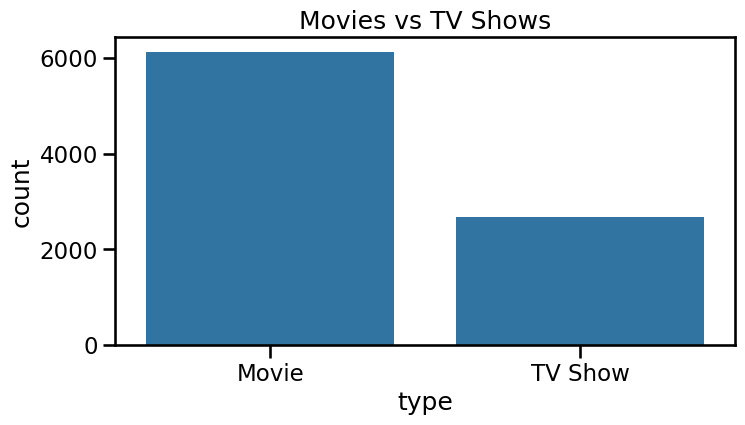

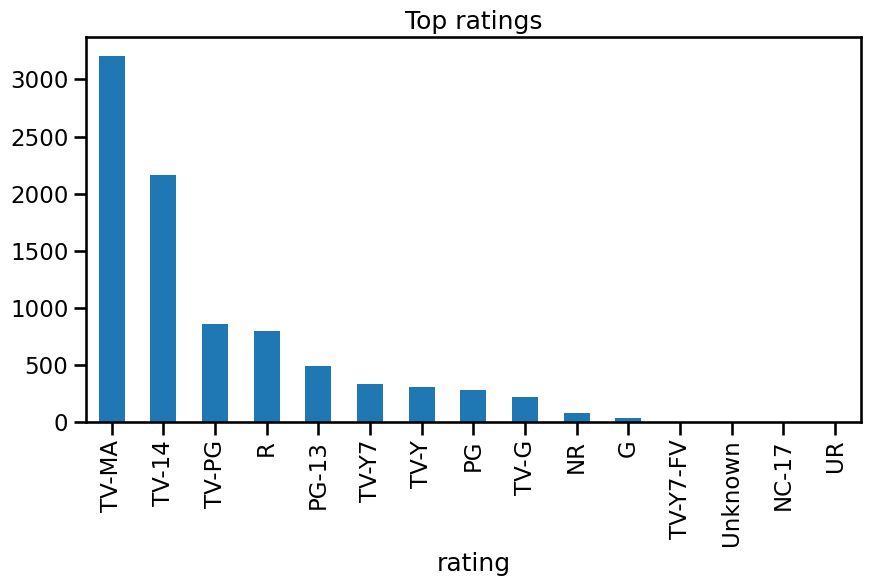

In [5]:
# Step 5 - univariate counts
display(Markdown("## Univariate checks"))

# Type distribution
type_counts = df_work['type'].value_counts()
display(type_counts)
display(Markdown(f"**Observation:** Type distribution - {type_counts.to_dict()}"))

# Ratings distribution
rating_counts = df_work['rating'].fillna('Unknown').value_counts().head(15)
display(Markdown("### Top ratings"))
display(rating_counts)

# Release year distribution - show decade buckets
df_work['release_decade'] = (df_work['release_year'] // 10 * 10).dropna()
decade_counts = df_work['release_decade'].value_counts().sort_index()
display(Markdown("### Titles by release decade"))
display(decade_counts)

# Simple plots
import matplotlib.ticker as mtick
plt.figure(figsize=(8,4))
sns.countplot(x='type', data=df_work, order=type_counts.index)
plt.title('Movies vs TV Shows')
plt.show()

plt.figure(figsize=(10,5))
rating_counts.plot(kind='bar')
plt.title('Top ratings')
plt.show()

### Top genres

genres_list
International Movies        2752
Dramas                      2427
Comedies                    1674
International TV Shows      1351
Documentaries                869
Action & Adventure           859
TV Dramas                    763
Independent Movies           756
Children & Family Movies     641
Romantic Movies              616
TV Comedies                  581
Thrillers                    577
Crime TV Shows               470
Kids' TV                     451
Docuseries                   395
Name: count, dtype: int64

**Observation:** Top genre is **International Movies** and accounts for approximately 14.2% of genre tags.

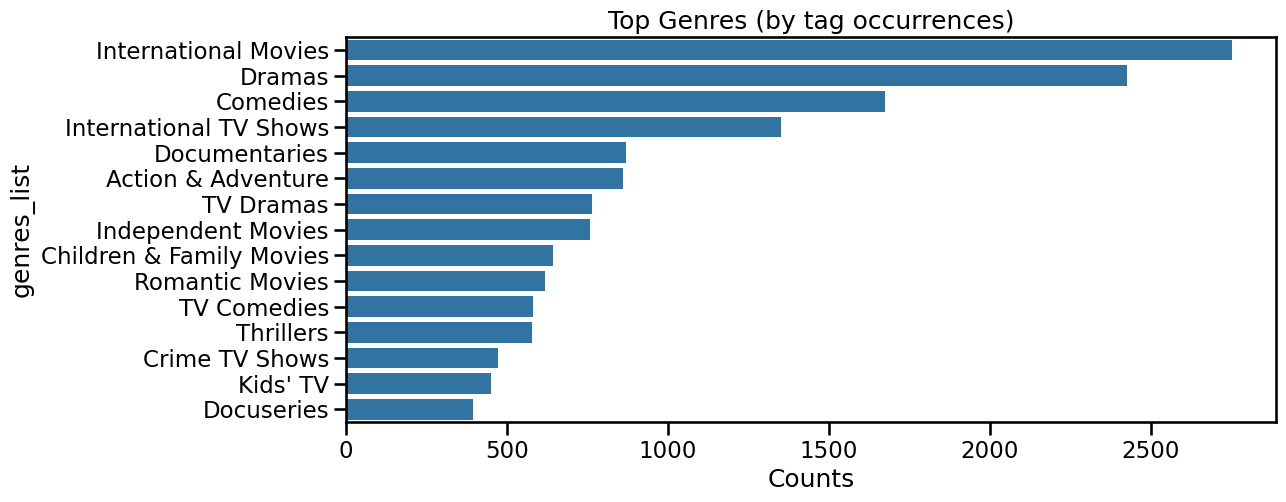

In [6]:
# Step 6 - genre analysis
genres = df_work.explode('genres_list')['genres_list'].dropna()
genre_counts = genres.value_counts()
top_genres = genre_counts.head(15)
display(Markdown("### Top genres"))
display(top_genres)

# Percent share for top genre
top_pct = round(100 * (genre_counts.iloc[0] / genre_counts.sum()), 1) if not genre_counts.empty else 0
display(Markdown(f"**Observation:** Top genre is **{genre_counts.index[0]}** and accounts for approximately {top_pct}% of genre tags."))

# Plot top genres
plt.figure(figsize=(12,5))
sns.barplot(x=top_genres.values, y=top_genres.index)
plt.title('Top Genres (by tag occurrences)')
plt.xlabel('Counts')
plt.show()

In [16]:
import os
os.makedirs('working', exist_ok=True)

### Top content-producing countries

country_list
United States     3690
India             1046
United Kingdom     806
Canada             445
France             393
Japan              318
Spain              232
South Korea        231
Germany            226
Mexico             169
China              162
Australia          160
Name: count, dtype: int64

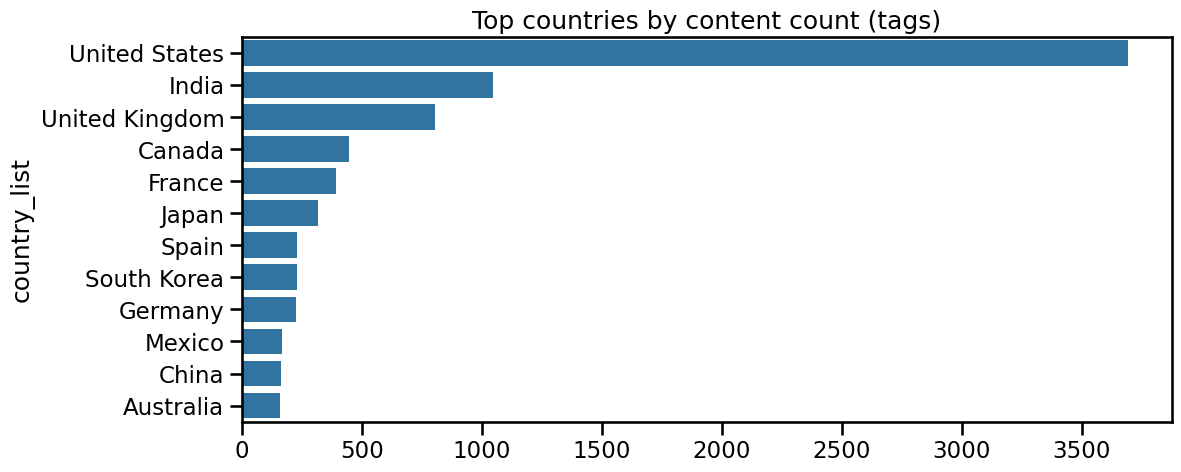

In [17]:
# Step 7 - country analysis
countries = df_work.explode('country_list')['country_list'].dropna()
country_counts = countries.value_counts()
top_countries = country_counts.head(12)
display(Markdown("### Top content-producing countries"))
display(top_countries)

# Plot
plt.figure(figsize=(12,5))
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Top countries by content count (tags)')
# i will be saving this
plt.savefig('working/top_countries_by_content.png', dpi=300, bbox_inches='tight')
plt.show()

### Titles added per year

year_added
2008.0       2
2009.0       2
2010.0       1
2011.0      13
2012.0       3
2013.0      10
2014.0      23
2015.0      73
2016.0     418
2017.0    1164
2018.0    1625
2019.0    1999
2020.0    1878
2021.0    1498
Name: count, dtype: int64

**Observation:** Largest absolute increase in titles added occurred in 2017 with 746 more titles than the year before.

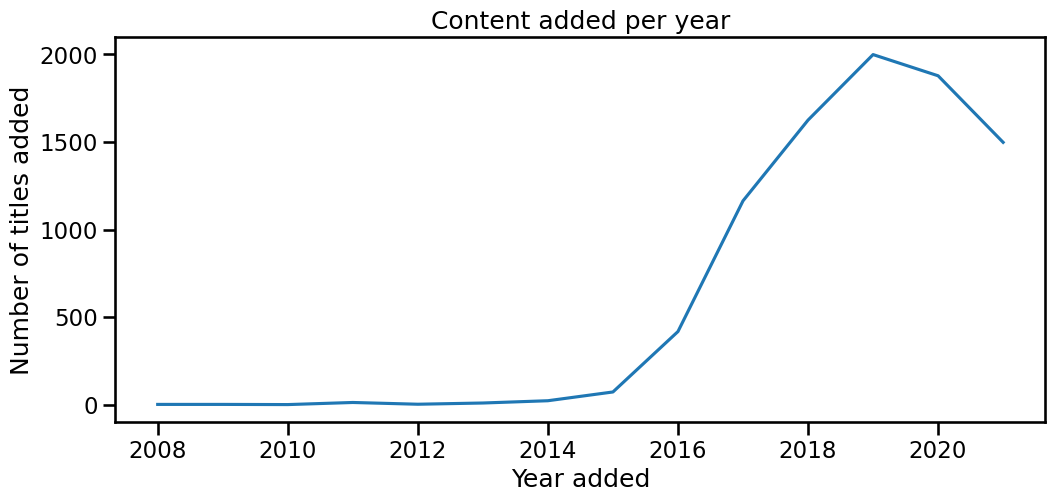

In [19]:
# Step 8 - time trends
year_added_counts = df_work['year_added'].dropna().value_counts().sort_index()
display(Markdown("### Titles added per year"))
display(year_added_counts.tail(15))  # show recent 15 years if available

# Which year had the largest absolute increase compared to previous year
year_diff = year_added_counts.diff().dropna()
if not year_diff.empty:
    max_inc_year = int(year_diff.idxmax())
    max_inc_val = int(year_diff.max())
    display(Markdown(f"**Observation:** Largest absolute increase in titles added occurred in {max_inc_year} with {max_inc_val} more titles than the year before."))

# Plot trend
plt.figure(figsize=(12,5))
year_added_counts.plot()
plt.title('Content added per year')
plt.ylabel('Number of titles added')
plt.xlabel('Year added')

# i will be saving this
import os
os.makedirs('working', exist_ok=True)
plt.savefig('working/content_added_per_year.png', dpi=300, bbox_inches='tight')
plt.show()

### Movie duration stats

- Median movie length: 98 minutes

- Mean movie length: 100 minutes

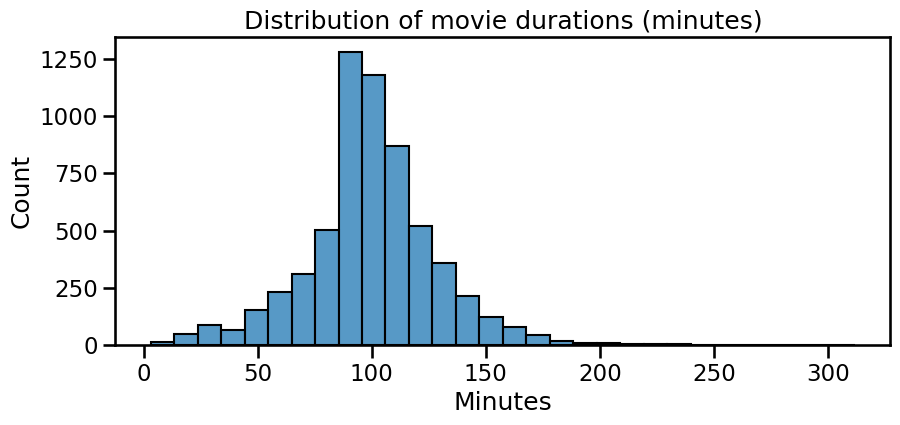

### TV seasons stats

- Median number of seasons: 1

- Mean number of seasons: 1.8

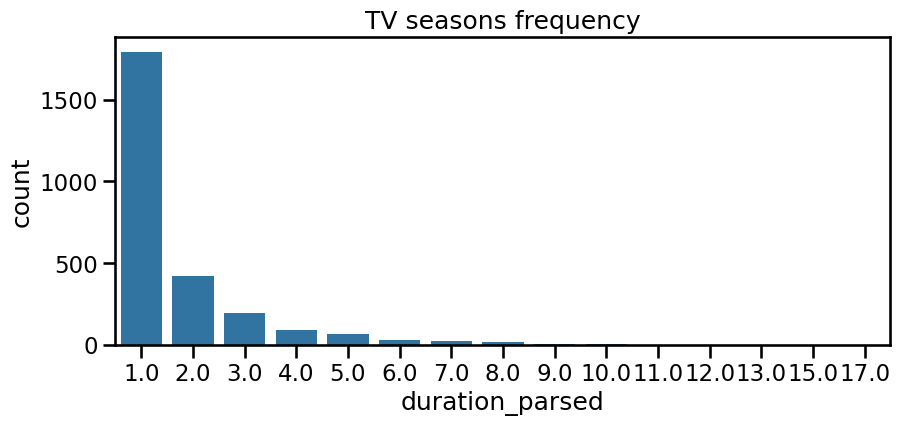

In [20]:
# Step 9 - duration analysis
# Movies - duration_parsed where duration_type == 'minutes'
movie_minutes = df_work[(df_work['type']=='Movie') & (df_work['duration_type']=='minutes')]['duration_parsed'].dropna().astype(float)
tv_seasons = df_work[(df_work['type']=='TV Show') & (df_work['duration_type']=='seasons')]['duration_parsed'].dropna().astype(float)

display(Markdown("### Movie duration stats"))
if not movie_minutes.empty:
    display(Markdown(f"- Median movie length: {movie_minutes.median():.0f} minutes"))
    display(Markdown(f"- Mean movie length: {movie_minutes.mean():.0f} minutes"))
    plt.figure(figsize=(10,4))
    sns.histplot(movie_minutes, bins=30, kde=False)
    plt.title('Distribution of movie durations (minutes)')
    plt.xlabel('Minutes')
    plt.show()
else:
    display(Markdown("No movie duration data parsed."))

display(Markdown("### TV seasons stats"))
if not tv_seasons.empty:
    display(Markdown(f"- Median number of seasons: {tv_seasons.median():.0f}"))
    display(Markdown(f"- Mean number of seasons: {tv_seasons.mean():.1f}"))
    plt.figure(figsize=(10,4))
    sns.countplot(x=tv_seasons)
    plt.title('TV seasons frequency')
    plt.show()
else:
    display(Markdown("No TV seasons data parsed."))

In [21]:
# Step 10 - directors and cast
# Directors
directors = df_work['director'].dropna().str.split(',').explode().str.strip()
top_directors = directors.value_counts().head(10)
display(Markdown("### Top directors by number of titles"))
display(top_directors)

# Cast - explode and show top actors
cast = df_work['cast'].dropna().str.split(',').explode().str.strip()
top_cast = cast.value_counts().head(15)
display(Markdown("### Top cast members by number of appearances"))
display(top_cast)

### Top directors by number of titles

director
Rajiv Chilaka          22
Jan Suter              21
Raúl Campos            19
Suhas Kadav            16
Marcus Raboy           16
Jay Karas              15
Cathy Garcia-Molina    13
Jay Chapman            12
Youssef Chahine        12
Martin Scorsese        12
Name: count, dtype: int64

### Top cast members by number of appearances

cast
Anupam Kher         43
Shah Rukh Khan      35
Julie Tejwani       33
Naseeruddin Shah    32
Takahiro Sakurai    32
Rupa Bhimani        31
Akshay Kumar        30
Om Puri             30
Yuki Kaji           29
Paresh Rawal        28
Amitabh Bachchan    28
Boman Irani         27
Rajesh Kava         26
Vincent Tong        26
Andrea Libman       25
Name: count, dtype: int64

In [22]:
# Very basic ML baseline - predict Movie vs TV Show using duration_parsed and release_year
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Prepare features - keep rows with type and some duration or release_year
df_model = df_work.copy()
df_model['is_movie'] = (df_model['type']=='Movie').astype(int)
# select only rows with release_year or duration_parsed
X = df_model[['duration_parsed','release_year']].fillna(-1)
y = df_model['is_movie']

# quick split and model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
acc = accuracy_score(y_test, pred)
display(Markdown(f"**Baseline logistic regression accuracy:** {acc:.3f}"))
display(Markdown("Classification report:"))
display(classification_report(y_test, pred, output_dict=False))

**Baseline logistic regression accuracy:** 0.997

Classification report:

'              precision    recall  f1-score   support\n\n           0       0.99      1.00      0.99       535\n           1       1.00      1.00      1.00      1227\n\n    accuracy                           1.00      1762\n   macro avg       0.99      1.00      1.00      1762\nweighted avg       1.00      1.00      1.00      1762\n'